In this notebook, we present two classical methods for calculating a flight plan. The first experiment is a non-optimization case where we disregard all climate information and simply take the path with the shortest distance. This is done to provide a benchmark for performance metrics such as $\Delta T$, time traveled, or operating cost. In the second experiment, the configuration space of the trajectory is represented as a 3D grid, where the weights are the climate costs of traversing between the centers of two voxels. We then use a generic pathfinding algorithm to determine each optimal climate trajectory.

# Import Libraries

In [3]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math
import networkx as nx
import itertools
from itertools import product 
from qiskit.quantum_info import Statevector
from importlib import reload
import utils.utils as ut
import matplotlib.ticker as ticker

# Load flight Data 

In [4]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [5]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [6]:
climate_df = pd.read_pickle("../data/climate_df.pkl")

# Classical non-optimization

Takes the shortest Euclidean distance between start and end point without altitude change.

In [5]:
classical_trajectory_arr = ut.get_classical_traj()
#np.save("../data/non_climate_trajectory_arr.npy",np.array(classical_trajectory_arr,dtype=object))

Example of shortest path trajectory:

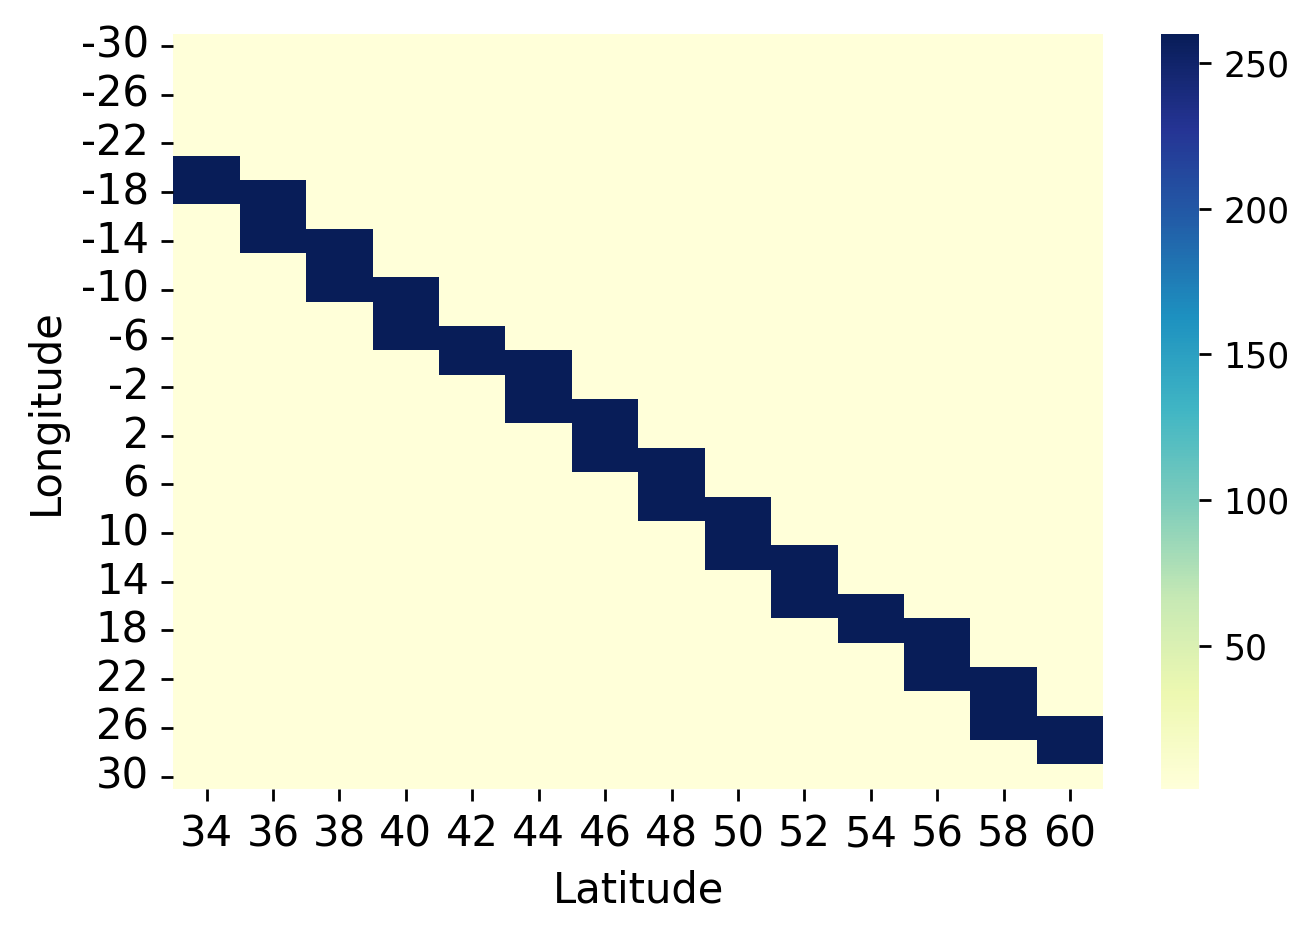

In [194]:
test_classical_traj = classical_trajectory_arr[11]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_classical_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = 260
                
fig, ax = plt.subplots(dpi=250) 
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0, cmap="YlGnBu")
ax.set_ylabel("Longitude")
ax.set_xlabel("Latitude")

    
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

ax.set_yticks(ax.get_yticks()[::2])
ax.legend
plt.show()

# Compute performance metric of flight schedule

In [122]:
classical_delta_T = np.sum([ut.C(tr) for tr in classical_trajectory_arr])
classical_delta_T

6.869211166897976e-06

In [176]:
np.sum([ut.consumed_fuel(tr)[0] for tr in classical_trajectory_arr])

2126269.6783333337

In [184]:
np.sum([ut.time_traveled(tr)for tr in classical_trajectory_arr])

numpy.timedelta64(2782152,'s')

# Classical Optimization

In [9]:
# G = ut.get_3d_graph()
# ut.add_weights_graph(G)
# nx.write_gpickle(G, "../data/w_graph.pkl")
G = nx.read_gpickle("../data/w_graph.pkl")

Each node in the graph has a set of edges whose weight is the climate cost of traveling from one voxel center to another.
As an example, take the node (4,4,4) with the following Edges:

- (3, 4, 4): {'w': 103.63} 
- (4, 3, 4): {'w': 134.84} 
- (5, 4, 4): {'w': 103.67} 
- (4, 5, 4): {'w': 135.80}
- (3, 4, 3): {'w': 112.62}
- (5, 4, 5): {'w': 102.56}

For this specific node, a given aircraft has the option to change the $x$ coordinate by $\pm 2 ^{\circ}$, the $y$ coordinate by $\pm 2 ^{\circ}$, or the $x$ coordinate by $\pm 2 ^{\circ}$ and the $z$ coordinate by $\pm 20 FL$.



The optimal trajectory for each of the 99 flights is then determined by calculating the shortest path for each final altitude.

In [17]:
classical_climate_trajectory_arr = []
for s_inx, (_, t, z, x_s, y_s, x_e, y_e) in enumerate(flight_df.to_numpy()):
    
    temp_save = []
    for z_e in ut.z_arr:
        tuple_path = ut.gen_shortest_path(G, x_s, y_s, z, x_e, y_e, z_e)
        if tuple_path == []:
            continue
        test_trajec = ut.tuple_path_to_trajec(tuple_path, start_index=s_inx)
        temp_save.append(test_trajec)
    temp_cost = [ut.C(tr) for tr in temp_save]
    min_inx = np.argmin(temp_cost)
    classical_climate_trajectory_arr.append(temp_save[min_inx])
    
#np.save("../data/c_climate_trajectory_arr.npy",np.array(classical_climate_trajectory_arr,dtype=object))

A simple visualization of one of the trajectories shows the change in altitude over the course of the flight, as well as the change in navigation compared to the plot above.

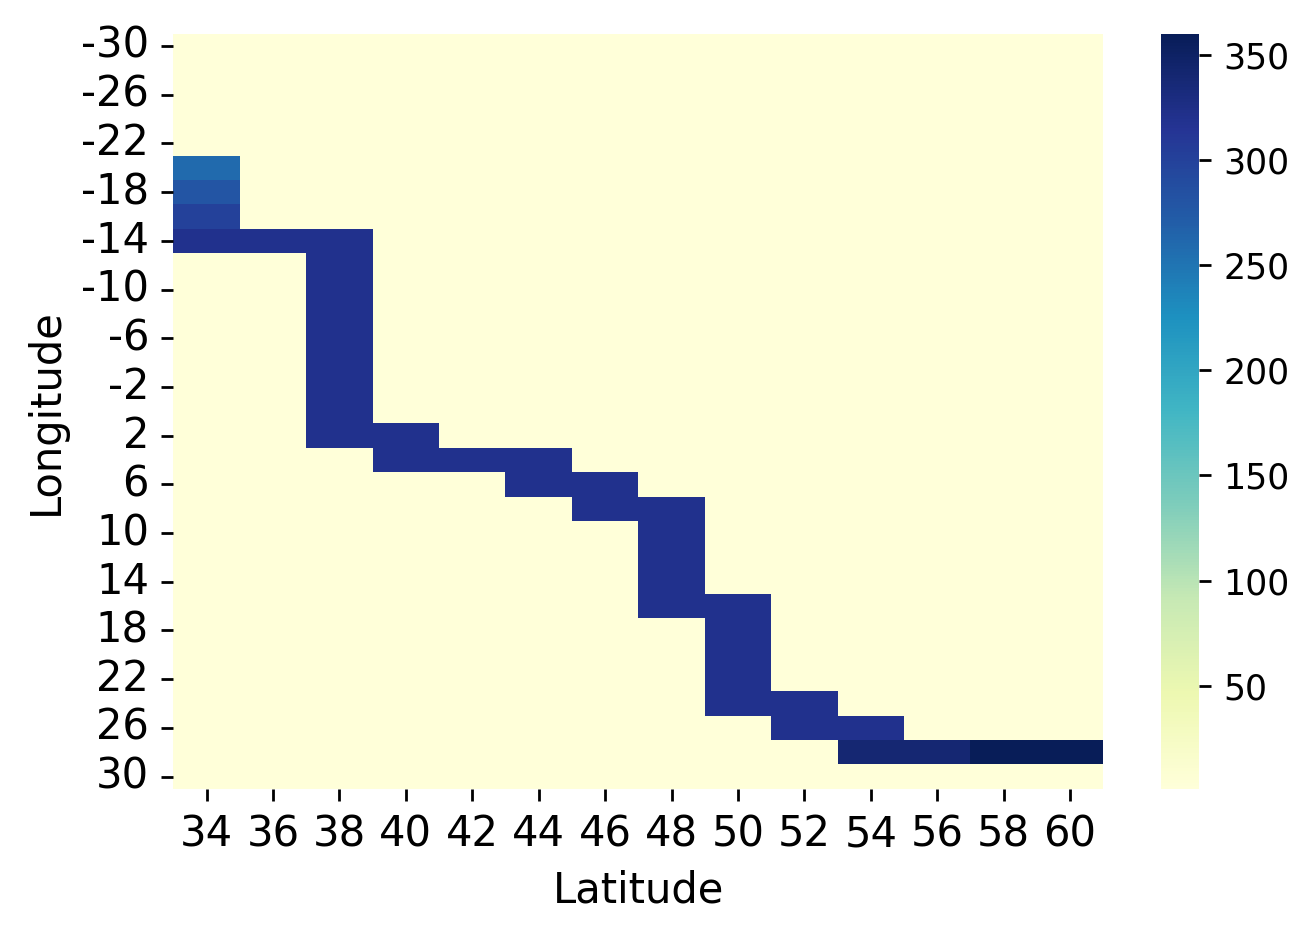

In [13]:
test_classical_traj = classical_climate_trajectory_arr[11]
box_2d = np.zeros((ut.x_arr.shape[0], ut.y_arr.shape[0]))

for c_1, i in enumerate(ut.x_arr):
    for c_2, j in enumerate(ut.y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_classical_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = l["z"]#
                
fig, ax = plt.subplots(dpi=250) 
ax = sns.heatmap(box_2d,xticklabels= ut.y_arr, yticklabels=ut.x_arr, linewidths=0, cmap="YlGnBu")
ax.set_ylabel("Longitude")
ax.set_xlabel("Latitude")
    
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

ax.set_yticks(ax.get_yticks()[::2])
ax.legend
plt.show()

# Compute performance metric of flight schedule

In [14]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in classical_climate_trajectory_arr])
classical_climate_delta_T

5.024468851809599e-06

In [15]:
np.sum([ut.consumed_fuel(tr)[0] for tr in classical_climate_trajectory_arr])

1854540.6850377168

In [16]:
np.sum([ut.time_traveled(tr)for tr in classical_climate_trajectory_arr])

numpy.timedelta64(2680147,'s')